In [102]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot


## Load Data

In [103]:
df_tweets = pd.read_csv("../Data/trump_tweets.csv", parse_dates = ['date'], index_col=7)
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
date,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f
2009-05-05 01:00:00,1.701461e+09,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34,f
2009-05-08 13:38:00,1.737480e+09,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15,f
2009-05-08 20:40:00,1.741161e+09,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11,f
2009-05-12 14:07:00,1.773561e+09,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321,f


In [104]:
df_doge = pd.read_csv("../Data/Daily-DOGE-USD.csv", parse_dates=['Date'], index_col=0)
df_doge.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [105]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

### Preparing Tweet Data

In [106]:
# Aligning Tweet Data with Doge Data
df_tweets = df_tweets.loc[(df_tweets.index > '2017-08-24')]
# Dropping ID column since it's unexpected to be useful
df_tweets = df_tweets.drop(columns=['id'], axis=1)

# Changing by the second data to by the day data
changed1 = df_tweets.groupby([df_tweets.index.date]).size().reset_index(name='Tweet Count')
changed2 = df_tweets.groupby([df_tweets.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_tweets = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_tweets = df_tweets.rename_axis('Date')
df_tweets.head()

,Tweet Count,favorites,retweets
Date,,,
2017-08-24,15,553551,146247
2017-08-25,14,676700,148426
2017-08-26,12,577719,130227
2017-08-27,11,733628,144351
2017-08-28,4,0,68447


### Preparing Doge Coin Data

In [107]:
# Aligning Doge Data with Tweet Data
df_doge = df_doge.loc[(df_doge.index < '2021-01-08')]
#df_doge = df_doge.drop(columns=['Open', 'High', 'Low', 'Adj Close'], axis=1)
df_doge.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0


Text(0.5, 1.0, 'DogeCoin Close')

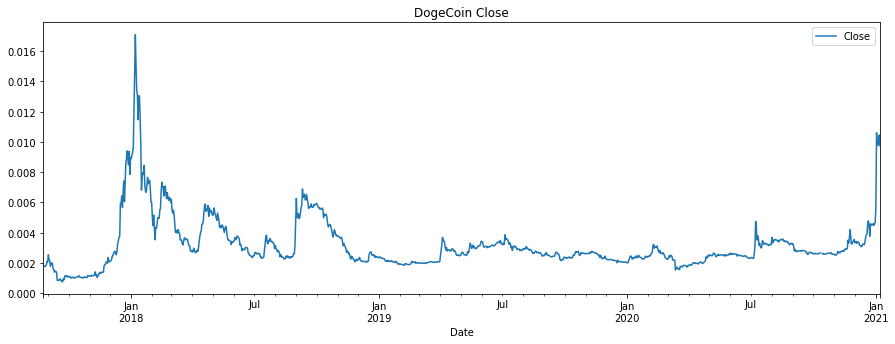

In [108]:
df_doge.plot(y='Close', figsize=(15,5)).set_title('DogeCoin Close')

### Converting Data for Supervised Learning

In [109]:
# Merging Two Data Sets Together
df = df_doge.merge(df_tweets, how='outer', left_index=True, right_index=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Tweet Count,favorites,retweets
Date,,,,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0,15.0,553551.0,146247.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0,14.0,676700.0,148426.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0,12.0,577719.0,130227.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0,11.0,733628.0,144351.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0,4.0,0.0,68447.0


In [110]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[9, 10, 11, 13, 14, 15, 16, 17]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(1212, 10)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var4(t)
1,0.059255,0.059033,0.078561,0.064961,0.064961,0.001089,0.092105,0.067624,0.053674,0.063369
2,0.063964,0.058199,0.081428,0.063369,0.063369,0.000462,0.085526,0.082669,0.054548,0.062634
3,0.062680,0.056365,0.079493,0.062634,0.062634,0.000252,0.072368,0.070577,0.047250,0.061532
4,0.062190,0.055642,0.080209,0.061532,0.061532,0.000342,0.065789,0.089623,0.052914,0.065512
5,0.061273,0.057921,0.080639,0.065512,0.065512,0.000625,0.019737,0.000000,0.022473,0.068083


## Running Model

In [135]:
# split into train, test, and prediction sets
values = reframed.values
n_predict = floor((len(values) * 0.10))
n_train = floor((len(values) * 0.80))
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(969, 1, 9) (969,) (122, 1, 9) (122,) (121, 1, 9) (121,)


In [185]:
# design network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation

model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 1, 128)            70656     
_________________________________________________________________
lstm_52 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
lstm_53 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 132,513
Trainable params: 132,513
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
14/14 - 5s - loss: 0.1235 - val_loss: 0.0728
Epoch 2/100
14/14 - 0s - loss: 0.0711 - val_loss: 0.0247
Epoch 3/100
14/14 - 0s - loss: 0.0581 - val_loss: 0.0226
Epoch 4/100
14/14 - 0s - loss: 0.0537 - val_loss: 0.0207
Epoch 5/100
14/14 - 0s - loss: 0.0495 - val_loss: 0.0167
Epoch 6/100
14/14 - 0s - loss: 0.0390 - val_loss: 0.0181
Epoch 7/100
14/14 - 0s - loss: 0.0266 - val_loss: 0.0182
Epoch 8/100
14/14 - 0s - loss: 0.0204 - val_loss: 0.0121
Epoch 9/100
14/14 - 0s - loss: 0.0208 - val_loss: 0.0125
Epoch 10/100
14/14 - 0s - loss: 0.0182 - val_loss: 0.0167
Epoch 11/100
14/14 - 0s - loss: 0.0189 - val_loss: 0.0082
Epoch 12/100
14/14 - 0s - loss: 0.0180 - val_loss: 0.0119
Epoch 13/100
14/14 - 0s - loss: 0.0193 - val_loss: 0.0064
Epoch 14/100
14/14 - 0s - loss: 0.0152 - val_loss: 0.0098
Epoch 15/100
14/14 - 0s - loss: 0.0144 - val_loss: 0.0078
Epoch 16/100
14/14 - 0s - loss: 0.0156 - val_loss: 0.0085
Epoch 17/100
14/14 - 0s - loss: 0.0161 - val_loss: 0.0083
Epoch 18/100
14/14 - 0s

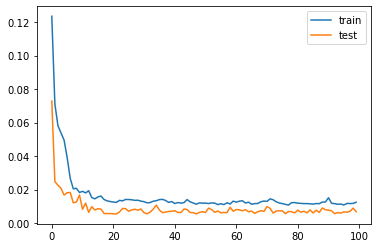

In [186]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=74, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Analysis

### Prediction Accuracy

In [187]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [188]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.001
Normalized RMSE: 0.066


### Plots

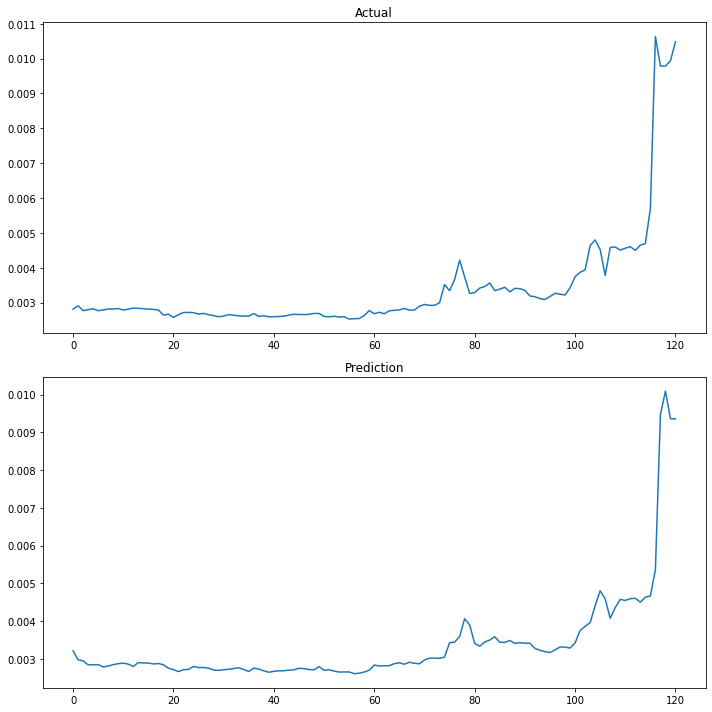

In [189]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Actual")
pyplot.title("Actual")
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction")
pyplot.tight_layout()
pyplot.show()

In [190]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,9)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


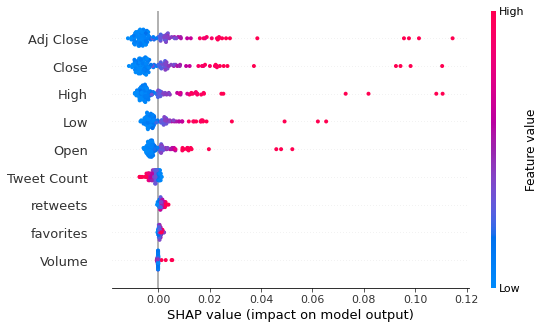

In [191]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)